In [1]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
config = {
  "save_plots": False,
  "load_models": True,
}

In [3]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset

# download dataset using ogb pytorch geometric loader.
dataset = PygNodePropPredDataset(name="ogbn-arxiv")

data = dataset[0] # pyg graph object

print(data)

Data(edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


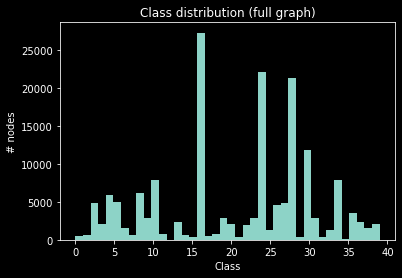

In [4]:
import matplotlib.pyplot as plt

plt.title("Class distribution (full graph)")
plt.hist(data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
if config["save_plots"] == True:
  plt.savefig("arxiv-class-dist.png")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: True
graph has # weakly connected components: 1
graph has # isolated nodes: 0


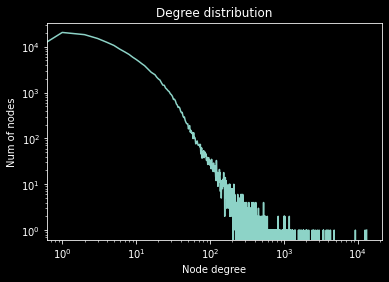

In [5]:
from lib import util

util.describe_graph(data, save_fig=config["save_plots"], log_scale=True)

## Split data set

year: 2010
year: 2015
year: 2020
graph sizes
year: 2010, # nodes: 12974, # edges: 21090


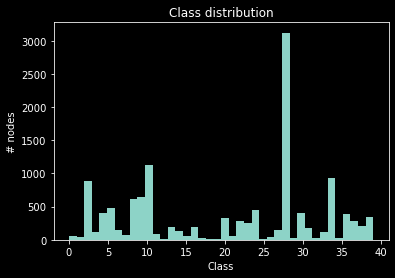

year: 2015, # nodes: 53160, # edges: 152226


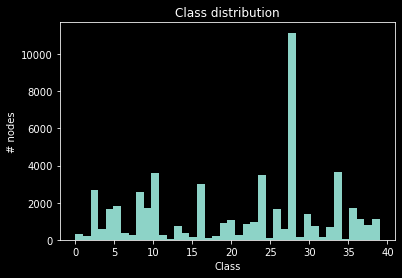

year: 2020, # nodes: 169343, # edges: 1166243


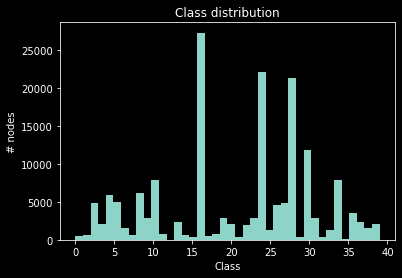

In [6]:
from lib.data import split_dataset, split

graphs = []

node_years = [2010,2015,2020]

for year in node_years:
  print("year: {}".format(year))
  indices = torch.nonzero(torch.where(data.node_year[:,0] <= year, 1, 0))[:,0].tolist()

  year_data = split(data, indices)

  # TODO: Retrieve test_indices only from current year
  train_data, calibration_indices, test_indices = split_dataset(year_data, test_frac=0.2, calibration_frac=0.2)
  graphs.append({
    "year": year,
    "data": year_data,
    "train_data": train_data,
    "calibration_indices": calibration_indices,
    "test_indices": test_indices,
  })

print("graph sizes")
for graph in graphs:
  print("year: {}, # nodes: {}, # edges: {}".format(graph["year"], graph["data"].x.shape[0], graph["data"].edge_index.shape[1]))
  plt.title("Class distribution")
  plt.hist(graph["data"].y.reshape(-1).detach().numpy(), dataset.num_classes)
  plt.xlabel("Class")
  plt.ylabel("# nodes")
  plt.show()

# GraphSAGE model

In [7]:
from lib.graphsage import GraphSAGE
from lib.evaluation import get_multiclass_classification_performance

from copy import deepcopy

args = {
    "num_layers": 3,
    "hidden_dim": 256,
    "lr": 0.01, # learning rate
    "epochs": 100,
}

models = {}
if config["load_models"] == True:
    for year in node_years:
        model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"])
        # load checkpoint
        model.load_state_dict(torch.load("models/model_{}.pt".format(year))["model_state_dict"])
        models[year] = model
else:
    model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"])

    # reset the parameters to initial random value
    model.reset_parameters()

    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

    loss_fn = torch.nn.NLLLoss()

    models = {}
    for graph in graphs:
        print("training: {}".format(graph["year"]))
        for epoch in range(1, 1 + args["epochs"]):
            loss = model.train_model(graph["train_data"], optimizer, loss_fn)
        models[graph["year"]] = deepcopy(model)
        
        # save checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        }, "model_{}.pt".format(graph["year"]))


        y_hat = model.predict(graph["data"])
        y_hat = y_hat[graph["test_indices"]]
        y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

        y_true = graph["data"].y[graph["test_indices"]].reshape(-1)

        acc, micro_f1 = get_multiclass_classification_performance(y_hat, y_true)

        print(f"Test acc: {100 * acc:.2f}%, "
            f"Test micro avg f1 score: {100 * micro_f1:.2f}%")

### Model performance per year

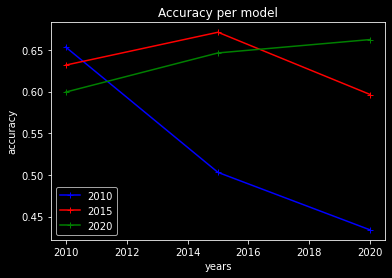

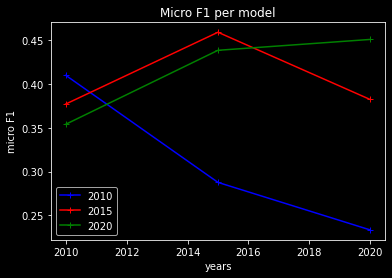

In [8]:
from lib.util import plot_multilines

years = node_years
accuracy_scores = []
macro_f1_scores = []
labels = []

for year, model in models.items():
  _accuracy_scores = []
  _macro_f1_scores = []

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices]
    y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1).detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    acc, macro_f1 = get_multiclass_classification_performance(y_hat, y_true)
    _accuracy_scores.append(acc)
    _macro_f1_scores.append(macro_f1)
  
  accuracy_scores.append(_accuracy_scores)
  macro_f1_scores.append(_macro_f1_scores)
  labels.append(year)

plot_multilines("Accuracy per model", years, accuracy_scores, labels, "years", "accuracy", save_file=config["save_plots"])
plot_multilines("Macro F1 per model", years, macro_f1_scores, labels, "years", "macro F1", save_file=config["save_plots"])

### Performance per node (in-)degreee

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


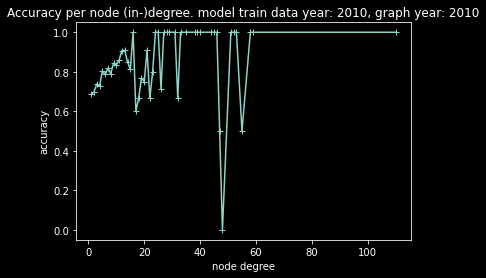

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


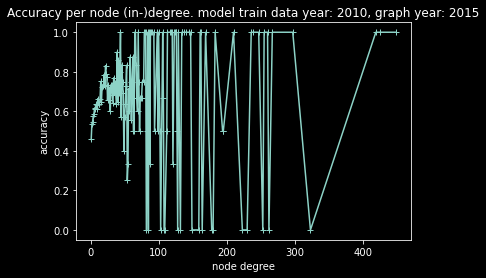

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


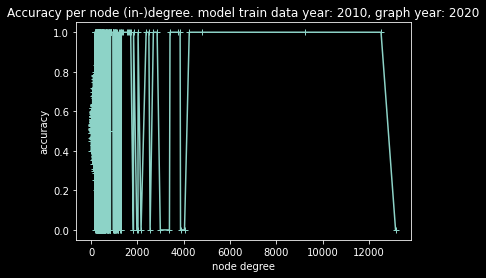

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


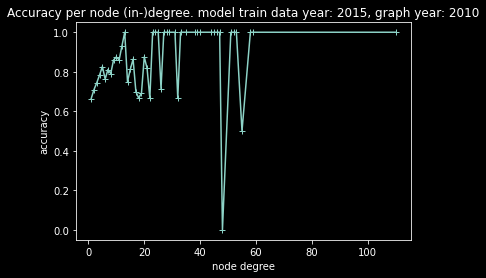

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


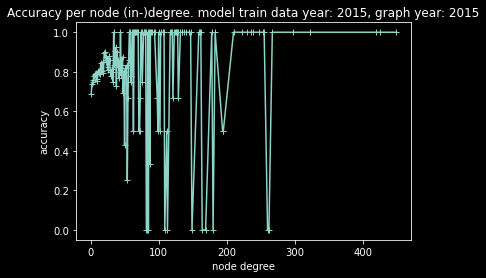

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


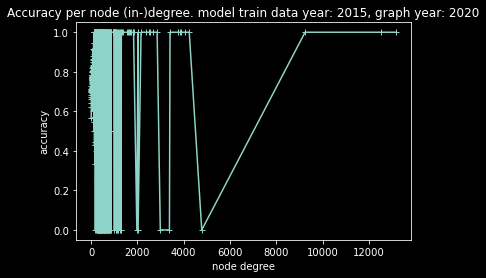

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


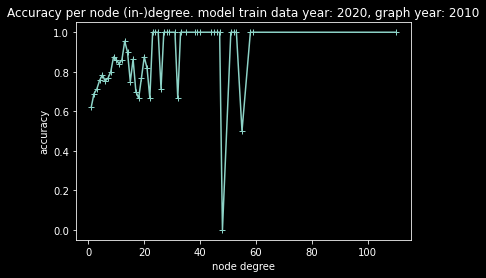

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


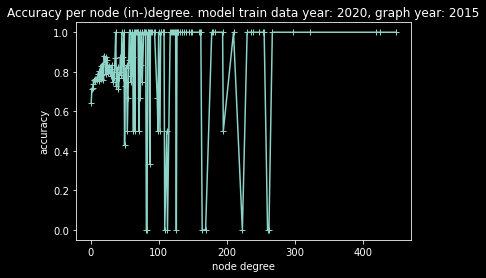

/Users/albin/Library/Mobile Documents/com~apple~CloudDocs/kth/masters_thesis/msc_thesis_code/lib/graphsage.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out.detach())


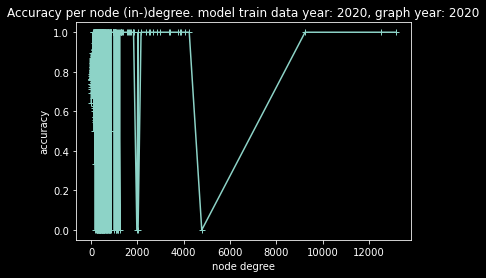

In [9]:
from lib.util import plot

for year, model in models.items():
  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)
    y_true = graph_data.y.reshape(-1)

    node_idx, node_degree = torch.unique(graph_data.edge_index[1], return_counts=True)
    nd = torch.zeros(graph_data.x.shape[0]).long()
    nd[node_idx] = node_degree

    degrees = torch.unique(node_degree)

    degrees_with_samples = []
    accs = []
    for d in degrees:
      degree_mask = nd == d
      if y_hat[degree_mask].shape[0] > 0:
        acc, _ = get_multiclass_classification_performance(y_hat[degree_mask], y_true[degree_mask])

        degrees_with_samples.append(d)
        accs.append(acc)

    plot("Accuracy per node (in-)degree. model train data year: {}, graph year: {}".format(year, graph["year"]), degrees_with_samples, accs, "node degree", "accuracy", save_file=config["save_plots"])

# Inductive Conformal Classifier (without resampling)

In [8]:
from lib.conformal_predictor import InductiveConformalClassifier, get_nonconformity_measure_for_classification

cal_model = models[2010]
cal_data = graphs[0]["data"]
calibration_indices = graphs[0]["calibration_indices"]

cal_y_hat = cal_model.predict(cal_data)
cal_y_hat = cal_y_hat[calibration_indices]

y_true = cal_data.y[calibration_indices]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)

cp = InductiveConformalClassifier(cal_alphas, dataset.num_classes)

## coverage and efficiency

In [9]:
from lib.evaluation import get_coverage_and_efficiency

CONFIDENCE_LEVEL = 0.95

def get_confidence_intervals(cp, y_hat, confidence_level=0.95):
  confidence_intervals = []
  for yi in y_hat:
    alphas = get_nonconformity_measure_for_classification(yi)
    ci = cp.predict(alphas, confidence_level)
    confidence_intervals.append(ci)
  
  return confidence_intervals

### Overall

In [10]:
from tabulate import tabulate
from lib.util import print_percentage

years = node_years

for year, model in models.items():
  coverages = ["coverage"]
  avg_prediction_set_sizes = ["avg prediction set size"]
  frac_singleton_preds = ["frac singleton predictions"]
  frac_empty_preds = ["frac empty predictions"]

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices].detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    confidence_intervals = get_confidence_intervals(cp, y_hat, CONFIDENCE_LEVEL)

    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

    coverages.append(coverage)
    avg_prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  scores = [coverages, avg_prediction_set_sizes, frac_singleton_preds, frac_empty_preds]

  print_percentage("\nICC perf. model year: {} with Confidence level".format(year), CONFIDENCE_LEVEL)
  print(tabulate(scores, headers=years))

KeyboardInterrupt: 

## ICC with resampling

In [14]:
years = node_years

for year, model in models.items():
  coverages = ["coverage"]
  avg_prediction_set_sizes = ["avg prediction set size"]
  frac_singleton_preds = ["frac singleton predictions"]
  frac_empty_preds = ["frac empty predictions"]

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]
    calibration_indices = graph["calibration_indices"]

    y_hat = model.predict(graph_data)
    cal_y_hat = y_hat[calibration_indices]

    y_true = graph_data.y[calibration_indices]
    y_true = y_true.reshape(-1).detach()

    cal_alphas = []
    for y_probas, yt in zip(cal_y_hat,y_true):
      y = yt.item()
      alphas = get_nonconformity_measure_for_classification(y_probas)
      cal_alphas.append(alphas[y])

    cal_alphas = torch.tensor(cal_alphas)

    cp = InductiveConformalClassifier(cal_alphas, dataset.num_classes)

    # y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices].detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    confidence_intervals = get_confidence_intervals(cp, y_hat, CONFIDENCE_LEVEL)

    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

    coverages.append(coverage)
    avg_prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  scores = [coverages, avg_prediction_set_sizes, frac_singleton_preds, frac_empty_preds]

  print_percentage("\nICC with sampling perf. model year: {} with Confidence level".format(year), CONFIDENCE_LEVEL)
  print(tabulate(scores, headers=years))


ICC with sampling perf. model year: 2010 with Confidence level: 95.00%
                                2010        2015        2020
--------------------------  --------  ----------  ----------
coverage                    0.940247   0.946482    0.951695
avg prediction set size     5.30802   13.5678     17.4768
frac singleton predictions  0.203547   0.0490971   0.0149108
frac empty predictions      0          0           0

ICC with sampling perf. model year: 2015 with Confidence level: 95.00%
                                2010      2015       2020
--------------------------  --------  --------  ---------
coverage                    0.935235  0.949774  0.950278
avg prediction set size     4.50077   4.54044   6.9628
frac singleton predictions  0.183886  0.151242  0.0595843
frac empty predictions      0         0         0

ICC with sampling perf. model year: 2020 with Confidence level: 95.00%
                                2010      2015      2020
--------------------------  -------- 

# Mondrian Conformal Prediction (MCP) without resampling

In [11]:
from lib.conformal_predictor import MondrianConformalClassifier

cal_model = models[2010]
cal_data = graphs[0]["data"]
calibration_indices = graphs[0]["calibration_indices"]

cal_y_hat = cal_model.predict(cal_data)
cal_y_hat = cal_y_hat[calibration_indices]

y_true = cal_data.y[calibration_indices]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

mcp = MondrianConformalClassifier(cal_alphas, cal_y)

## Performance
### Overall

In [13]:
def get_confidence_intervals_mcp(cp, y_hat, confidence_level=0.95):
  confidence_intervals = []
  for yi in y_hat:
    alphas = get_nonconformity_measure_for_classification(yi)
    max_y = yi.argmax(dim=-1, keepdim=True)
    ci = cp.predict(alphas, max_y, confidence_level)
    confidence_intervals.append(ci)
  
  return confidence_intervals


years = node_years

for year, model in models.items():
  coverages = ["coverage"]
  avg_prediction_set_sizes = ["avg prediction set size"]
  frac_singleton_preds = ["frac singleton predictions"]
  frac_empty_preds = ["frac empty predictions"]

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices].detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    confidence_intervals = get_confidence_intervals_mcp(mcp, y_hat, CONFIDENCE_LEVEL)

    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

    coverages.append(coverage)
    avg_prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  scores = [coverages, avg_prediction_set_sizes, frac_singleton_preds, frac_empty_preds]

  print_percentage("\nMCP perf. model year: {} with Confidence level".format(year), CONFIDENCE_LEVEL)
  print(tabulate(scores, headers=years))

MCP perf. model year: 2010 with Confidence level: 95.00%
                                2010      2015      2020
--------------------------  --------  --------  --------
coverage                    0.90478   0.794865  0.757411
avg prediction set size     4.27911   4.73279   4.90617
frac singleton predictions  0.306091  0.238431  0.160446
frac empty predictions      0         0         0
MCP perf. model year: 2015 with Confidence level: 95.00%
                                2010      2015         2020
--------------------------  --------  --------  -----------
coverage                    0.937163  0.938676  0.91399
avg prediction set size     5.76022   5.79769   6.09841
frac singleton predictions  0.232845  0.212284  0.137652
frac empty predictions      0         0         2.95264e-05
MCP perf. model year: 2020 with Confidence level: 95.00%
                                2010      2015         2020
--------------------------  --------  --------  -----------
coverage                  

# Node (in-)degree MCP

In [14]:
from lib.conformal_predictor import NodeDegreeMondrianConformalClassifier

cal_model = models[2010]
cal_data = graphs[0]["data"]
calibration_indices = graphs[0]["calibration_indices"]

cal_y_hat = cal_model.predict(cal_data)
cal_y_hat = cal_y_hat[calibration_indices]

y_true = cal_data.y[calibration_indices]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

BINS = torch.tensor([0,1,5,10,20,100]) # boundaries[i-1] < input[x] <= boundaries[i]

# get node degrees
c_node_ids, c_node_degrees = torch.unique(cal_data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(cal_data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes


c_node_degrees_bins = torch.bucketize(cal_node_degrees, BINS)

nd_mcp = NodeDegreeMondrianConformalClassifier(cal_alphas, cal_y, c_node_degrees_bins)

## Performance

### Overall

In [15]:
def get_confidence_intervals_nd_mcp(cp, y_hat, node_degrees, confidence_level=0.95):
    confidence_intervals = []
    for yi in y_hat:
        alphas = get_nonconformity_measure_for_classification(yi)
        ci = cp.predict(alphas, confidence_level, node_degrees)
        confidence_intervals.append(ci)

    return confidence_intervals


years = node_years

for year, model in models.items():
    avg_coverages = ["coverage"]
    avg_avg_prediction_set_sizes = ["avg prediction set size"]
    avg_frac_singleton_preds = ["frac singleton predictions"]
    avg_frac_empty_preds = ["frac empty predictions"]

    for graph in graphs:
        graph_data = graph["data"]
        test_indices = graph["test_indices"]

        y_hat = model.predict(graph_data)
        y_hat = y_hat[test_indices].detach()

        y_true = graph_data.y[test_indices].reshape(-1).detach()

        # get node degrees
        node_ids, some_node_degrees = torch.unique(
            graph_data.edge_index[1], return_counts=True)
        node_degrees = torch.zeros(graph_data.x.shape[0]).long()
        node_degrees[node_ids] = some_node_degrees

        node_degrees = node_degrees[test_indices]  # only use calibration nodes

        node_degrees_bins = torch.bucketize(node_degrees, BINS)

        degrees = torch.unique(node_degrees_bins)

        coverages = []
        avg_prediction_set_sizes = []
        frac_singleton_preds = []
        frac_empty_preds = []
        samples_per_bin = []

        for d in degrees:
            degree_mask = node_degrees_bins == d

            confidence_intervals = get_confidence_intervals_nd_mcp(
                nd_mcp, y_hat[degree_mask], d, CONFIDENCE_LEVEL)

            coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(
                confidence_intervals, y_true[degree_mask])

            samples_per_bin.append(y_true[degree_mask].shape[0])
            coverages.append(coverage)
            avg_prediction_set_sizes.append(avg_prediction_set_size)
            frac_singleton_preds.append(frac_singleton_pred)
            frac_empty_preds.append(frac_empty_pred)

        dataset_size = torch.sum(torch.tensor(samples_per_bin))
        avg_coverages.append(torch.sum(torch.tensor(
            coverages) * torch.tensor(samples_per_bin) / dataset_size))
        avg_avg_prediction_set_sizes.append(torch.sum(torch.tensor(
            avg_prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size))
        avg_frac_singleton_preds.append(torch.sum(torch.tensor(
            frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size))
        avg_frac_empty_preds.append(torch.sum(torch.tensor(
            frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size))
        #plot("Samples per bin", BINS, samples_per_bin, "Node degree bins (>)", "# samples", config["save_plots"])

    scores = [avg_coverages, avg_avg_prediction_set_sizes,
              avg_frac_singleton_preds, avg_frac_empty_preds]

    print_percentage("\nnd-MCP perf. model year: {} with Confidence level".format(
        year), CONFIDENCE_LEVEL)
    print(tabulate(scores, headers=years))


MCP perf. model year: 2010 with Confidence level: 95.00%
                                  2010       2015       2020
--------------------------  ----------  ---------  ---------
coverage                    0.947186    0.840858   0.77182
avg prediction set size     5.46569     5.8323     5.7715
frac singleton predictions  0.202776    0.159895   0.124985
frac empty predictions      0.00115652  0.0112867  0.0398016
MCP perf. model year: 2015 with Confidence level: 95.00%
                                  2010       2015       2020
--------------------------  ----------  ---------  ---------
coverage                    0.96569     0.958239   0.904305
avg prediction set size     7.03624     6.53574    6.58533
frac singleton predictions  0.127217    0.13243    0.11285
frac empty predictions      0.00231303  0.0099699  0.0362289
MCP perf. model year: 2020 with Confidence level: 95.00%
                                  2010      2015       2020
--------------------------  ----------  --------

# Node degree Weighted Conformal Prediction

In [ ]:
from lib.conformal_predictor import NodeDegreeWeightedConformalClassifier

cal_model = models[2010]
cal_data = graphs[0]["data"]
calibration_indices = graphs[0]["calibration_indices"]

cal_y_hat = cal_model.predict(cal_data)
cal_y_hat = cal_y_hat[calibration_indices]

y_true = cal_data.y[calibration_indices]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

# get node degrees
c_node_ids, c_node_degrees = torch.unique(cal_data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(cal_data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes

nd_weigthe_cp = NodeDegreeWeightedConformalClassifier(cal_alphas, cal_y, cal_node_degrees)

In [ ]:
def get_confidence_intervals_weighted(cp, y_hat, degrees, confidence_level=0.95):
  confidence_intervals = []
  for yi, d in zip(y_hat,degrees):
    alphas = get_nonconformity_measure_for_classification(yi, version="v2")
    ci = cp.predict(alphas, d, confidence_level)
    confidence_intervals.append(ci)
  
  return confidence_intervals

years = node_years

for year, model in models.items():
  coverages = ["coverage"]
  avg_prediction_set_sizes = ["avg prediction set size"]
  frac_singleton_preds = ["frac singleton predictions"]
  frac_empty_preds = ["frac empty predictions"]

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices].detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    # get node degrees
    node_ids, some_node_degrees = torch.unique(graph_data.edge_index[1], return_counts=True)
    node_degrees = torch.zeros(graph_data.x.shape[0]).long()
    node_degrees[node_ids] = some_node_degrees

    confidence_intervals = get_confidence_intervals_weighted(nd_weigthe_cp, y_hat, node_degrees, CONFIDENCE_LEVEL)

    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

    coverages.append(coverage)
    avg_prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  scores = [coverages, avg_prediction_set_sizes, frac_singleton_preds, frac_empty_preds]

  print_percentage("\nnode weighted cp perf. model year: {} with Confidence level".format(year), CONFIDENCE_LEVEL)
  print(tabulate(scores, headers=years))


ICC perf. model year: 2010 with Confidence level: 95.00%
                                  2010        2015       2020
--------------------------  ----------  ----------  ---------
coverage                    0.937163    0.838695    0.776544
avg prediction set size     4.97456     5.34669     5.25384
frac singleton predictions  0.203547    0.150207    0.108126
frac empty predictions      0.00231303  0.00630173  0.0262785
ICC perf. model year: 2015 with Confidence level: 95.00%
                                  2010       2015       2020
--------------------------  ----------  ---------  ---------
coverage                    0.957594    0.958239   0.907169
avg prediction set size     6.29453     5.85026    5.86633
frac singleton predictions  0.123747    0.121332   0.0892878
frac empty predictions      0.00231303  0.0057374  0.0265442
ICC perf. model year: 2020 with Confidence level: 95.00%
                                  2010        2015       2020
--------------------------  --------

# Embedding distance weighted CP

In [11]:
from lib.conformal_predictor import EmbeddingDistanceWeightedConformalClassifier

cal_model = models[2010]
cal_data = graphs[0]["data"]
calibration_indices = graphs[0]["calibration_indices"]

cal_model.set_return_embeds(False)
cal_y_hat = cal_model.predict(cal_data)
cal_y_hat = cal_y_hat[calibration_indices]

cal_model.set_return_embeds(True)
cal_embeddings = cal_model.predict(cal_data)
cal_embeddings = cal_embeddings[calibration_indices]

y_true = cal_data.y[calibration_indices]
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

emb_weighted_cp = EmbeddingDistanceWeightedConformalClassifier(cal_alphas, cal_y, cal_embeddings)

In [12]:
def get_confidence_intervals_emb_weighted(cp: EmbeddingDistanceWeightedConformalClassifier, y_hat, embeddings, confidence_level=0.95):
  confidence_intervals = []
  for yi, emb in zip(y_hat,embeddings):
    alphas = get_nonconformity_measure_for_classification(yi, version="v2")
    ci = cp.predict(alphas, emb, confidence_level)
    confidence_intervals.append(ci)
  
  return confidence_intervals

years = node_years

for year, model in models.items():
  coverages = ["coverage"]
  avg_prediction_set_sizes = ["avg prediction set size"]
  frac_singleton_preds = ["frac singleton predictions"]
  frac_empty_preds = ["frac empty predictions"]

  for graph in graphs:
    graph_data = graph["data"]
    test_indices = graph["test_indices"]

    model.set_return_embeds(False)
    y_hat = model.predict(graph_data)
    y_hat = y_hat[test_indices].detach()

    y_true = graph_data.y[test_indices].reshape(-1).detach()

    model.set_return_embeds(True)
    embeddings = model.predict(graph_data)
    embeddings = embeddings[test_indices]

    confidence_intervals = get_confidence_intervals_emb_weighted(emb_weighted_cp, y_hat, embeddings, CONFIDENCE_LEVEL)

    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

    coverages.append(coverage)
    avg_prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  scores = [coverages, avg_prediction_set_sizes, frac_singleton_preds, frac_empty_preds]

  print_percentage("\nembedding distance weighted cp perf. model year: {} with Confidence level".format(year), CONFIDENCE_LEVEL)
  print(tabulate(scores, headers=years))



embedding distance weighted cp perf. model year: 2010 with Confidence level: 95.00%
                                2010      2015      2020
--------------------------  --------  --------  --------
coverage                    0.93138   0.830606  0.79429
avg prediction set size     4.69584   5.08362   5.19523
frac singleton predictions  0.238628  0.178988  0.122475
frac empty predictions      0         0         0

embedding distance weighted cp perf. model year: 2015 with Confidence level: 95.00%
                                2010      2015       2020
--------------------------  --------  --------  ---------
coverage                    0.963763  0.962378  0.937817
avg prediction set size     5.96955   5.6297    5.84138
frac singleton predictions  0.143408  0.134876  0.0986772
frac empty predictions      0         0         0

embedding distance weighted cp perf. model year: 2020 with Confidence level: 95.00%
                                2010      2015       2020
-----------------